In [49]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import random

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%matplotlib inline

In [50]:
bbf_df = pd.read_csv("Data/Beat_Bobby_Flay_Wikipedia_Data.csv", engine = "python")

In [51]:
bbf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 11 columns):
SeriesEpisodeNumber      297 non-null int64
Season                   297 non-null int64
SeasonEpisodeNumber      297 non-null int64
Title                    297 non-null object
OriginalAirdate          297 non-null object
Guests                   297 non-null object
FirstRoundIngredient     297 non-null object
FirstRoundContestants    297 non-null object
SecondRoundJudges        297 non-null object
SecondRoundDish          297 non-null object
SecondRoundWinner        297 non-null object
dtypes: int64(3), object(8)
memory usage: 25.6+ KB


In [ ]:
# df_obj = bbf_df.select_dtypes(['object']) # identify object columns
# bbf_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip()) # Strip whitespace for object columns.

### What is Bobby's overall record?

Create flag for `SecondRoundWinner`

0 = Bobby Lost

1 = Bobby Dominates

In [52]:
bbf_df["BobbyDominates"] = np.where(bbf_df["SecondRoundWinner"] == "Bobby Flay", 1, 0)

In [53]:
overall_record = bbf_df.groupby("BobbyDominates").agg({"BobbyDominates":["count"]})
overall_record

,BobbyDominates
,count
BobbyDominates,
0,111
1,186


In [54]:
print("Bobby's winning percentage: ", 
      (overall_record.iloc[1,0] / (overall_record.iloc[0,0] + overall_record.iloc[1,0])).round(2)*100, "%")

Bobby's winning percentage:  63.0 %


63% is honestly lower than I thought, but still very impressive.

### How has Bobby done over time?

In [7]:
# get results within a season
seasonal_record = bbf_df.groupby(["Season"]).agg({"BobbyDominates":["mean"]}).round(4)
seasonal_record.reset_index(inplace = True)
# print(seasonal_record.columns)

Text(0.5, 1.0, 'Bobby Wins Most Episodes Most Seasons')

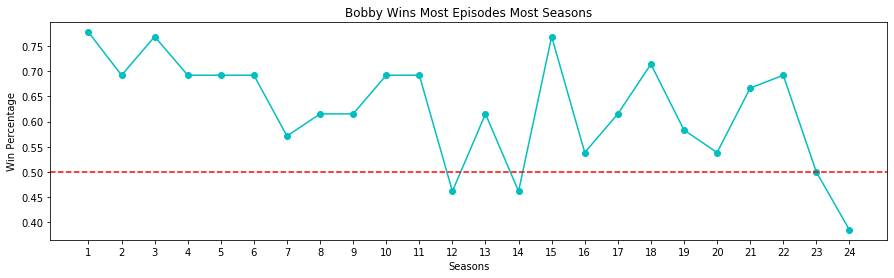

In [8]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)

ax1.plot(seasonal_record["Season"], seasonal_record[("BobbyDominates", "mean")],
         color = "c",
         marker = "o")
ax1.axhline(y = 0.5, color = 'r', linestyle = '--')
plt.xticks(seasonal_record["Season"])
plt.xlabel("Seasons")
plt.ylabel("Win Percentage")
plt.title("Bobby Wins Most Episodes Most Seasons")

Bobby has only had three losing seasons, and one .500 season.

Simply put, Bobby dominates. 

### Wich Guest has appeared on the show the most?

In [83]:
# split the Guests column into separate columns for every guest
guests_df = pd.concat([bbf_df["Guests"], bbf_df["Guests"].str.split(',', expand = True)], axis = 1)

# rename columns
guests_df.columns = ["Guests","Guest1","Guest2","Guest3"]

# stack guests 
guests_series = pd.concat([guests_df["Guest1"], 
                           guests_df["Guest2"], 
                           guests_df["Guest3"]],
                          axis = 0).dropna() # axis = 0 for rows

# strip whitespace so to not capture duplicates
guests_series = guests_series.str.strip()

# create dataframe
guests_df = pd.DataFrame({'Guests':guests_series})

# group by Guest and count
guests_df_grp = guests_df.groupby("Guests").agg({"Guests":["count"]})

# exclude first level of multi-indexed columns resulting from the groupby
guests_df_grp.columns = guests_df_grp.columns.droplevel(0)

# sort values
guests_df_grp = guests_df_grp.sort_values("count", ascending = False).reset_index()

# specify top quantile (0 to 1)
quant = guests_df_grp.quantile(0.95)

# show which Guests have made the most appearances
guests_df_grp.loc[guests_df_grp["count"] >= quant[0], :]

,Guests,count
0,Alex Guarnaschelli,45
1,Scott Conant,36
2,Anne Burrell,35
3,Katie Lee,35
4,Sunny Anderson,34
5,Michael Symon,30
6,Geoffrey Zakarian,23
7,Ted Allen,19
8,Amanda Freitag,14
9,Giada De Laurentiis,14


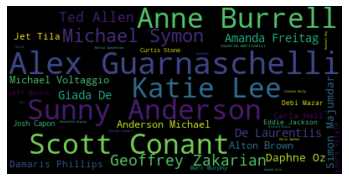

In [91]:
# get all dishes into a string of text
text = " ".join(dish for dish in guests_df.Guests)

# Create and generate a word cloud image:
# wc = wordcloud.WordCloud().generate(text)
wc = wordcloud.WordCloud(max_font_size = 100, max_words = 100, background_color = "black").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Alex Guarnaschelli appears the most on the show.

### What is the record of a Guest?

This has nothing to do with who beats Bobby, but the guests joke about beating Bobby because their choice of contestant beats Bobby.

take the split columns of Guests from above and the Bobby Dominated indicator

union only the Guests columns and Bobby win indicator column

groupby by Guests and count/mean Yes's/1s

can do a bar chat of win percentages by a Guest

In [10]:
# create indicator for Guests winning
bbf_df["GuestsDominate"] = np.where(bbf_df["SecondRoundWinner"] == "Bobby Flay", 0, 1)

# split the Guests column into separate columns for every guest
guests_record_df = pd.concat([bbf_df["Guests"], bbf_df["Guests"].str.split(',', expand = True)], axis = 1)

# rename columns
guests_record_df.columns = ["Guests","Guest1","Guest2","Guest3"]

# bind columns together
guests_record_df = pd.concat([guests_record_df, bbf_df["GuestsDominate"]], axis = 1)

# get Guest1 and GuestsDominate indicator
guest1_df = guests_record_df.loc[:, ["Guest1", "GuestsDominate"]]

# get Guest2 and GuestsDominate indicator
guest2_df = guests_record_df.loc[:, ["Guest2", "GuestsDominate"]]

# get Guest3 and GuestsDominate indicator
guest3_df = guests_record_df.loc[:, ["Guest3", "GuestsDominate"]]

# rename columns so they could be stacked
guest1_df.columns = ["Guest","GuestsDominate"]
guest2_df.columns = ["Guest","GuestsDominate"]
guest3_df.columns = ["Guest","GuestsDominate"]

# stack guests 
guests_record_df = pd.concat([guest1_df, 
                              guest2_df, 
                              guest3_df],
                             axis = 0).dropna() # axis = 0 for rows

# strip whitespace so to not capture duplicates
guests_record_df["Guest"] = guests_record_df["Guest"].str.strip()

# group by Guest and count
guests_record_grp = guests_record_df.groupby("Guest").agg({"Guest":["count"], "GuestsDominate":["mean"]})

# exclude first level of multi-indexed columns resulting from the groupby
guests_record_grp.columns = guests_record_grp.columns.droplevel(0)

# show the top winning percentages for Guests who have appeared at least five times
(guests_record_grp.loc[guests_record_grp["count"] >= 5, :]
 .sort_values("mean", ascending = False)
 .reset_index())

,Guest,count,mean
0,Valerie Bertinelli,5,0.600000
1,Giada De Laurentiis,14,0.571429
2,Sunny Anderson,34,0.470588
3,Damaris Phillips,11,0.454545
4,Michael Voltaggio,11,0.454545
5,Jeff Mauro,7,0.428571
6,Alex Guarnaschelli,45,0.422222
7,Ted Allen,19,0.421053
8,Carla Hall,10,0.400000
9,Michael Symon,30,0.400000


Only 25 Guests have appeared five or more times on the show. Of these Guests, Valerie Bertinelli has the best winning percentage against Bobby. Valeria and Giada are the only ones with winning records. 

Looks like Bobby really wants Marc Murphy and Debi Mazar to be Guests on the show.

In [11]:
guests_record_df.iloc[[3,6, 59, 67], :]

,Guest,GuestsDominate
3,Alex Guarnaschelli,1
6,Alex Guarnaschelli,0
59,Donatella Arpaia,1
67,Katie Lee,0


### What is Bobby's record against other Food Network personalities?

In [13]:
# split the Guests column into separate columns for every guest
guest_personalities_df = pd.concat([bbf_df["Guests"],
                                    bbf_df["Guests"].str.split(',', expand = True)],
                                   axis = 1) # axis = 1 for column bind

# rename columns
guest_personalities_df.columns = ["Guests","Guest1","Guest2","Guest3"]

# identify which episodes Bobby faces an Equal/Guest
guest_personalities_df["BobbyFacesPersonality"] = np.where(guest_personalities_df["Guest2"].isnull(), 1, 0)

# bind columns together
guest_personalities_df = pd.concat([guest_personalities_df, 
                                    bbf_df["BobbyDominates"],
                                    bbf_df["SecondRoundWinner"]],
                                   axis = 1)

guest_personalities_df.groupby("BobbyFacesPersonality").agg({"BobbyDominates":"mean"})

,BobbyDominates
BobbyFacesPersonality,
0,0.641379
1,0.000000


Bobby has not beat a Guest/Foodnetwork Personality.

In [14]:
guest_personalities_df.loc[guest_personalities_df["BobbyFacesPersonality"] == 1,
                           ["SecondRoundWinner","BobbyDominates"]]

,SecondRoundWinner,BobbyDominates
81,Alex Guarnaschelli,0
94,Anne Burrell,0
139,Alex Guarnaschelli,0
140,Damaris Phillips,0
141,Marcus Samuelsson,0
142,Amanda Freitag,0
296,Buddy Valastro,0


Looks like these chefs have Bobby's number. 

### Who are the chefs that have beat Bobby multiple times?

Group by SecondRoundWinner and count all names.

exclude Bobby Flay

In [15]:
mult_winner_grp = bbf_df.groupby("SecondRoundWinner").agg({"GuestsDominate":["sum"]})

# exclude first level of multi-indexed columns resulting from the groupby
mult_winner_grp.columns = mult_winner_grp.columns.droplevel(0)

# show the top winning percentages for Guests who have appeared at least five times
(mult_winner_grp.loc[mult_winner_grp["sum"] > 1, :]
 .sort_values("sum", ascending = False)
 .reset_index())

,SecondRoundWinner,sum
0,Alex Guarnaschelli,2


Alex Guarnaschelli is the only chef to defeat Bobby TWICE!

### What Judge has appeared the most on the show?

In [ ]:
split Judge into 3 columns

union only those columns

groupby by Judges and count Judges

can do a word cloud for number of appearances by a Guest

In [16]:
bbf_df.columns

Index(['SeriesEpisodeNumber', 'Season', 'SeasonEpisodeNumber', 'Title',
       'OriginalAirdate', 'Guests', 'FirstRoundIngredient',
       'FirstRoundContestants', 'SecondRoundJudges', 'SecondRoundDish',
       'SecondRoundWinner', 'BobbyDominates', 'GuestsDominate'],
      dtype='object')

In [17]:
# split the Judges column into separate columns for every judge
judges_df = pd.concat([bbf_df["SecondRoundJudges"], 
                       bbf_df["SecondRoundJudges"].str.split(',', expand = True)], axis = 1)

# rename columns
judges_df.columns = ["Judges","Judge1","Judge2","Judge3"]

# stack judges
judges_series = pd.concat([judges_df["Judge1"], 
                           judges_df["Judge2"], 
                           judges_df["Judge3"]],
                          axis = 0).dropna() # axis = 0 for rows

# strip whitespace so to not capture duplicates
judges_series = judges_series.str.strip()

# create dataframe
judges_df = pd.DataFrame({'Judges': judges_series})

# group by Judges and count
judges_df_grp = judges_df.groupby("Judges").agg({"Judges":["count"]})

# exclude first level of multi-indexed columns resulting from the groupby
judges_df_grp.columns = judges_df_grp.columns.droplevel(0)

# sort values
judges_df_grp = judges_df_grp.sort_values("count", ascending = False).reset_index()

# specify top quantile (0 to 1)
quant = judges_df_grp.quantile(0.95)

# show which Guests have made the most appearances
judges_df_grp.loc[judges_df_grp["count"] >= quant[0], :]

,Judges,count
0,Frank Prisinzano,17
1,Leah Cohen,16
2,Michael Psilakis,16
3,Madison Cowan,15
4,Lourdes Castro,14
5,Ivy Stark,14
6,Hugh Mangum,13
7,Michael Lomonaco,13
8,Ed McFarland,12
9,Tricia Williams,11


Frank Prisinzano has appeared the most as a judge. 

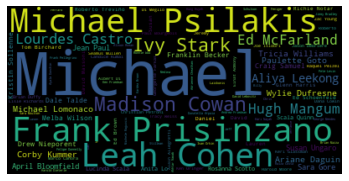

In [94]:
# get all dishes into a string of text
text = " ".join(dish for dish in judges_df.Judges)

# Create and generate a word cloud image:
# wc = wordcloud.WordCloud().generate(text)
wc = wordcloud.WordCloud(max_font_size = 72, max_words = 100, background_color = "black").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Are there biased judges (for/against Bobby)?

In [ ]:
take the split columns of Judges from above and the Bobby Dominated indicator

union only the Judges columns and Bobby win indicator column

groupby by Judges and count/mean Yes's/1s

can do a bar chat of win percentages by a Judges

In [18]:
# split the Guests column into separate columns for every guest
judges_record_df = pd.concat([bbf_df["SecondRoundJudges"], 
                              bbf_df["SecondRoundJudges"].str.split(',', expand = True)], axis = 1)

# rename columns
judges_record_df.columns = ["Judges","Judge1","Judge2","Judge3"]

# bind columns together
judges_record_df = pd.concat([judges_record_df, bbf_df["GuestsDominate"]], axis = 1)

# get Judge1 and GuestsDominate indicator
judge1_df = judges_record_df.loc[:, ["Judge1", "GuestsDominate"]]

# get Judge2 and GuestsDominate indicator
judge2_df = judges_record_df.loc[:, ["Judge2", "GuestsDominate"]]

# get Judge3 and GuestsDominate indicator
judge3_df = judges_record_df.loc[:, ["Judge3", "GuestsDominate"]]

# rename columns so they could be stacked
judge1_df.columns = ["Judge","GuestsDominate"]
judge2_df.columns = ["Judge","GuestsDominate"]
judge3_df.columns = ["Judge","GuestsDominate"]

# stack guests 
judges_record_df = pd.concat([judge1_df, 
                              judge2_df, 
                              judge3_df],
                             axis = 0).dropna() # axis = 0 for rows

# strip whitespace so to not capture duplicates
judges_record_df["Judge"] = judges_record_df["Judge"].str.strip()

# group by Judge and count
judges_record_grp = judges_record_df.groupby("Judge").agg({"Judge":["count"], "GuestsDominate":["mean"]})

# exclude first level of multi-indexed columns resulting from the groupby
judges_record_grp.columns = judges_record_grp.columns.droplevel(0)

# show the top winning percentages for Judges who have appeared at least five times
(judges_record_grp.loc[judges_record_grp["count"] >= 10, :]
 .sort_values("mean", ascending = False)
 .reset_index())

,Judge,count,mean
0,Tricia Williams,11,0.636364
1,Paulette Goto,11,0.545455
2,Leah Cohen,16,0.437500
3,Ed McFarland,12,0.416667
4,Frank Prisinzano,17,0.411765
5,Madison Cowan,15,0.400000
6,Wylie Dufresne,10,0.400000
7,Ivy Stark,14,0.285714
8,Corby Kummer,11,0.272727
9,Michael Psilakis,16,0.250000


When Tricia Williams appears as a judge, it seems the contestant wins  more often. For 11 appearances, that seems like some pretty biased results. Of course, correlation does not mean causation, and 11 appearances isn't enough to statistically prove bias. However, Bobby would probably prefer to have Tricia appear less often on the show. 

### How does Bobby do against contestants who have been judges?

In [19]:
bbf_df.columns

Index(['SeriesEpisodeNumber', 'Season', 'SeasonEpisodeNumber', 'Title',
       'OriginalAirdate', 'Guests', 'FirstRoundIngredient',
       'FirstRoundContestants', 'SecondRoundJudges', 'SecondRoundDish',
       'SecondRoundWinner', 'BobbyDominates', 'GuestsDominate'],
      dtype='object')

In [20]:
# split the Guests column into separate columns for every guest
contestant_record_df = pd.concat([bbf_df["FirstRoundContestants"], 
                                  bbf_df["FirstRoundContestants"].str.split(',', expand = True)], axis = 1)

# rename columns
contestant_record_df.columns = ["Contestant","Contestant1","Contestant2"]

# # strip whitespace so to not capture duplicates
# bbf_df["SecondRoundWinner"] = bbf_df["SecondRoundWinner"].str.strip()

# bind columns together
contestant_record_df = pd.concat([contestant_record_df, bbf_df["BobbyDominates"]], axis = 1)

# get Contestant1 and BobbyDominates indicator
contestant1_df = contestant_record_df.loc[:, ["Contestant1", "BobbyDominates"]]

# get Contestant2 and BobbyDominates indicator
contestant2_df = contestant_record_df.loc[:, ["Contestant2", "BobbyDominates"]]

# rename columns so they could be stacked
contestant1_df.columns = ["Contestant","BobbyDominates"]
contestant2_df.columns = ["Contestant","BobbyDominates"]

# stack contestants
contestant_record_df = pd.concat([contestant1_df, 
                                  contestant2_df],
                                 axis = 0).dropna() # axis = 0 for rows

# strip whitespace so to not capture duplicates
contestant_record_df["Contestant"] = contestant_record_df["Contestant"].str.strip()

# get a unique list of the judges
judges_uniq_df = judges_df.drop_duplicates()

# get contestants who have been judges (join)
contestants_merged_df = pd.merge(contestant_record_df, judges_uniq_df,
                                 left_on = "Contestant",
                                 right_on = "Judges",
                                 how = "left")

# get contestants who have been judges (indicator)
contestants_merged_df["IsJudge"] = np.where(contestants_merged_df["Contestant"] == 
                                            contestants_merged_df["Judges"], "Yes", "No")

# group by Judge and get winning percentage
contestants_merged_df.groupby("IsJudge").agg({"BobbyDominates":["mean"]})

# # exclude first level of multi-indexed columns resulting from the groupby
# contestants_merged_grp.columns = contestants_merged_grp.columns.droplevel(0)

,BobbyDominates
,mean
IsJudge,
No,0.630931
Yes,0.520000


Bobby is more human than god when he faces off against a contestant who is a judge on the show.

### Word Cloud on Bobby's dishes he's won at

In [28]:
import wordcloud

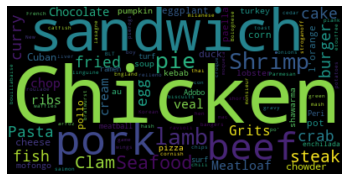

In [82]:
# subset to the contests Bobby won
winning_dishes = bbf_df.loc[bbf_df["BobbyDominates"] == 1]

# get the dishes column
winning_dishes = winning_dishes[["SecondRoundDish"]]

# get all dishes into a string of text
text = " ".join(dish for dish in winning_dishes.SecondRoundDish)

# Create and generate a word cloud image:
# wc = wordcloud.WordCloud().generate(text)
wc = wordcloud.WordCloud(max_font_size = 100, max_words = 100, background_color = "black").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud on Bobby's dishes he's lost at

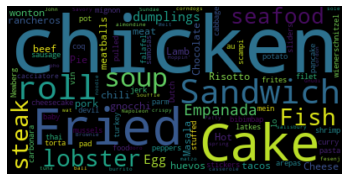

In [81]:
# subset to the contests Bobby won
winning_dishes = bbf_df.loc[bbf_df["BobbyDominates"] == 0]

# get the dishes column
winning_dishes = winning_dishes[["SecondRoundDish"]]

# get all dishes into a string of text
text = " ".join(dish for dish in winning_dishes.SecondRoundDish)

# Create and generate a word cloud image:
wc = wordcloud.WordCloud(max_font_size = 100, max_words = 100, background_color = "black").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

As "chicken" and "sandwich" seem to be dishes that are commonly made in the Second Round, it's tough to make a decisive opinion on what Bobby is really good or bad at cooking. A few things that stick out are that in the WordCloud of dishes Bobby has won, he is good at cooking beef and pork, and in the WordCloud of dishes Bobby has lost, he is not good at baking (i.e. cake).